# Network reconstruction based on scIDseq data 

In this notebook we explore the single-cell MRA and CNR network reconstructions of primary human epidermal stem cells treated, stimulated for 30 minutes with EGF only (Control) or with EGF + a p70 or RPS6 inhibitor.

Cells were also classified into 9 distinct cell state clusters based on epitopes that did not show a differential response to the inhibitor treatment. By fitting a linear model relating epitope expression to drug treatment and cell state cluster, we identified a significant interaction between drug treatment and cell state cluster for RPS6. Specifically, we found that in **cluster 2 RPS6 is unresponsive to p70S6K inhibition and in cluster 6 to RSK inhibition,**

We will explore the origins of this by reconstruction the signaling networks upstream of RPS6 using comparative network reconstruction. 
Here we focus on the MAPK and AKT subnetworks.
In another notebook we will perform a network reconstruction using many more epitopes.

Specifically, we will include the following nodes in the network
  * MAPK pathway 
    * EGFR_P_Y1045 and EGFR_P_Y1173
    * ERK1_2_P
    * RSK1_P_T359 and RSK1_P_S380 
  * AKT
    * AKT1_P and AKT123_P
    * MTOR_P
    * GSK3B_P
    * RIBOSOMAL_S6_P
  * Output nodes (not all phospho, but need to know how they are influenced. 
    outgoing edges set to 0)
    * CFOS_P, CMYC", CDC2, CDK4, CYCLIN_E, CYCLIN_B1 and RB_P

To reduce computational load, we will first fix the model topology. We do this by starting with a network with canonical interactions, and adding edges if they are recurrently added in a bootstrap. To this end, we initially ignore differences between clusters.

We then perform CNR, where we compare:

  * All clusters individually
  * Cluster 2 vs all other clusters
  * Cluster 6 vs all other clusters


In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.collections
import scmra
import networkx as nx
import random
import itertools
import pickle
import cplex

%matplotlib inline  
%load_ext autoreload

%autoreload 2

# Temporary fix for autocompletion. See this issue 
# https://github.com/conda-forge/conda-forge-repodata-patches-feedstock/issues/81#event-3664361521
%config Completer.use_jedi = False

# Fix some font issues
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['font.family'] = "sans-serif"

In [2]:
dat = pd.read_csv("../../data/processed/TMM_normalised_with_clusters_matrix.csv")

dat.treatment = [s.replace("_", ".") for s in dat.treatment]
dat.sample_id = [s.replace("_", ".") for s in dat.sample_id]
dat.index = dat.sample_id
#dat.columns = [s.replace("_", ".") for s in list(dat.columns)]

group_annot = dict()
for group in dat.cluster.unique():
    group_annot[str(group)] = list(dat[dat.cluster == group].index)

cell_annot = dict()
for tx in dat.treatment.unique():
    cell_annot[tx] = list(dat[dat.treatment == tx].index)
    
tx_annot = {
    "EGF": None,
    "iRSK.EGF": "RSK1T359", # ["RSK1S380", ],
    "ip70S6K.EGF": "RPS6"
}

df_annot = dat[["sample_id", "treatment", "cluster"]]
df_annot
    
dat = dat.drop(["Unnamed: 0", "sample_id", "plate_number", "treatment", "cluster"], axis=1)

In [3]:
# Select the nodes to include
ab_use_phospho = [
    # MAPK
    "EGFR_P_Y1045", "EGFR_P_Y1173",
    "ERK1_2_P",
    "RSK1_P_T359", #"RSK1_P_S380", 
    #AKT
    "AKT1_P", "AKT123_P",
    "MTOR_P",
    "GSK3B_P",
    "RIBOSOMAL_S6_P",
    # Output nodes (not all phospho, but need to know how they are influenced. 
    # outgoing edges set to 0)
    "CFOS_P", "CMYC", # Not a phospho-p, but "activated" by pRSK
    "CDC2", "CDK4", "CYCLIN_E", "CYCLIN_B1", "RB_P",
]

# Explicitly map each antibody to a node to match total and phospho, where applicable.
# Also make sure node names are valid (no uderscores ect.)
ab_mapping_phospho = {
    # Phospho-antibodies
    # MAPK
    "EGFR_P_Y1045": "EGFRY1045", "EGFR_P_Y1173": "EGFRY1173",
    "ERK1_2_P": "ERK12",
    "RSK1_P_T359": "RSK1T359", #"RSK1_P_S380": "RSK1S380", 
    #AKT
    "AKT1_P": "AKT1", "AKT123_P": "AKT123",
    "MTOR_P": "MTOR",
    "GSK3B_P": "GSK3B",
    "RIBOSOMAL_S6_P": "RPS6", 
    # Output nodes
    "CMYC": "CMYC", "CFOS_P": "CFOS", # Not a phospho-p, but "activated" by pRSK
    "CDC2": "CDC2", "CDK4": "CDK4", "CYCLIN_E": "CYCLINE", "CYCLIN_B1": "CYCLINB1", 
    "RB_P": "RB",

}
ab_mapping_phospho_inv = {v: k for k, v in ab_mapping_phospho.items()}


# Total proteins to use
ab_use_tot = [
    "ERK1_2", "AKT2"
]

# Map to nodes.
ab_mapping_tot = {    
    # Total protein antibodies 
    "ERK1_2": "ERK12",
    "AKT2": ["AKT1", "AKT123"]
}
ab_mapping_tot_inv = {    
    # Total protein antibodies 
    "ERK12": "ERK1_2",
    "AKT1": "AKT2",
    "AKT123": "AKT2"
}


ab_use = ab_use_phospho + ab_use_tot
ab_mapping = {**ab_mapping_tot, **ab_mapping_phospho}
ab_mapping_inv = {**ab_mapping_tot_inv, **ab_mapping_phospho_inv}


assert set(ab_use_phospho) == set(ab_mapping_phospho.keys())
assert set(ab_use_tot) == set(ab_mapping_tot.keys())
assert set(ab_mapping_tot_inv.keys()).issubset(set(ab_mapping_phospho_inv.keys()))

def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list) or isinstance(i, tuple): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

NODE_NAMES = [
    # MAPK
    "EGFRY1045", "EGFRY1173", "ERK12", "RSK1T359", #"RSK1S380",
    #AKT
    "AKT1", "AKT123", "MTOR", "GSK3B", "RPS6", "RB",
     # Output nodes
    "CMYC","CFOS", "CDC2", "CDK4", "CYCLINE", "CYCLINB1"
]

assert set(NODE_NAMES) == set(flatten(ab_mapping.values()))



In [52]:
OUTPUT_NODES = ["CMYC", "CFOS", "CDC2", "CDK4", "CYCLINE", "CYCLINB1"] #, "H2A", "H3"]
OUTPUT_EDGES = []
for out_node in output_nodes:
    OUTPUT_EDGES += [(node, out_node) for node in NODE_NAMES if node is not out_node]
OUTPUT_EDGES

ALL_EDGES = list(itertools.permutations(NODE_NAMES, 2))

# # Some checks
# # assert set(ab_name_mapping.values()) == set(NODE_NAMES)
dat_use = dat[ab_use]
dat_use.head()

,EGFR_P_Y1045,EGFR_P_Y1173,ERK1_2_P,RSK1_P_T359,AKT1_P,AKT123_P,MTOR_P,GSK3B_P,RIBOSOMAL_S6_P,CFOS_P,CMYC,CDC2,CDK4,CYCLIN_E,CYCLIN_B1,RB_P,ERK1_2,AKT2
sample_id,,,,,,,,,,,,,,,,,,
plate.10.171,0.003442,0.002487,0.002596,0.003720,0.005265,0.003933,0.002811,0.007134,0.073248,0.006503,0.008048,0.002326,0.002985,0.003563,0.012358,0.050469,0.002255,0.004242
plate.2.171,0.002636,0.002940,0.002431,0.005745,0.003534,0.003213,0.002363,0.003573,0.104189,0.004820,0.009068,0.001719,0.002767,0.003352,0.022569,0.060667,0.002441,0.002981
plate.3.171,0.002196,0.002200,0.006063,0.004318,0.003190,0.003248,0.002051,0.004810,0.080980,0.004452,0.007457,0.001675,0.002800,0.003691,0.017495,0.019658,0.002510,0.003589
plate.6.171,0.003045,0.003054,0.003144,0.003561,0.003630,0.002825,0.002693,0.006072,0.150466,0.003080,0.013184,0.001927,0.002811,0.002823,0.007750,0.047284,0.002879,0.003188
plate.8.171,0.002998,0.003436,0.002497,0.004656,0.004749,0.003646,0.002497,0.009178,0.085174,0.005644,0.007937,0.001856,0.002714,0.004071,0.010678,0.010344,0.003115,0.003752


In [53]:
CANNONICAL_EDGES = [
    # MAPK pathway
    ("ERK12", "EGFRY1045"), ("ERK12", "EGFRY1173"), 
    ("AKT1", "EGFRY1045"), ("AKT1",  "EGFRY1173"), 
    ("AKT123", "EGFRY1045"), ("AKT123",  "EGFRY1173"),
    ("RSK1T359", "ERK12"), # ("RSK1S380", "ERK12"),
    ("CMYC", "ERK12"), ("CFOS", "ERK12"), 
    ("RPS6", "RSK1T359"), #("RPS6", "RSK1S380"), # RSK
    # AKT pathway
    ("MTOR", "AKT1"), ("MTOR", "AKT123"), ("GSK3B", "AKT1"), ("GSK3B", "AKT123"),
    ("RPS6", "MTOR"), # MTOR
]

assert set(flatten(CANNONICAL_EDGES)).issubset(set(NODE_NAMES))

Which nodes are not in the starting network?

In [6]:
set(NODE_NAMES) - set(flatten(CANNONICAL_EDGES))

{'CDC2', 'CDK4', 'CYCLINB1', 'CYCLINE', 'RB'}

## Comparative network reconstruction

We can either treat drug treatments as a perturbation to the network, or model each treatment as a different "state" for which we fit a different model. For now, we start with the former.

### Esteblish sensible model complexity

We will first scan $\eta$, the hyperparameter that sets the number of edges, to determine the model topology.
This will be identified by plotting residuals against number of edges included in the model. 
To this end, we will initially ignore differences between clusters.

For the data preparation, we need to calculate the deviations of all cells relative to the median of the control cells.

Next, let's see what happens when we include the inhibitor treated cells in the network reconstruction. We model the treatments as a negative perturbation to RSK1 (iRSK) or RPS6 (p70S6K inhibition, as p70 itself is not measured).

When allowing adges to differ, we can either allow them to be different in all clusters, or we can focus on a single cluster an allow only this one to differ from all other cluters

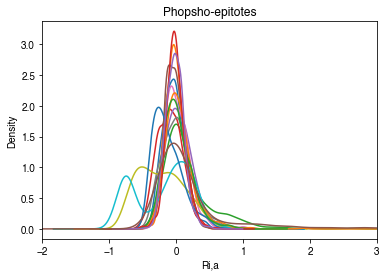

In [7]:
# Get the median of all control cells
ctr_median = dat_use.loc[cell_annot["EGF"]].median()
dat_scaled = (dat_use - ctr_median)/ctr_median
#dat_scaled = np.log2((dat.loc[cell_annot["EGF"]])/ctr_median)

rglob_mra = dat_scaled[ab_use_phospho].transpose()
# Make clean names for the node names
rglob_mra.index = [ab_mapping[ab_name] for ab_name in rglob_mra.index]

# Plot the disctributions
rglob_mra.transpose()[NODE_NAMES].plot.kde(legend=False);
plt.xlim(-2, 3)
plt.xlabel("Ri,a");
plt.ylabel("Density")
plt.title("Phopsho-epitotes");
plt.show();


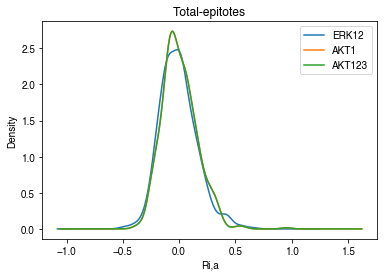

In [8]:
nn, an = zip(*[(nn, an) for nn, an in ab_mapping_tot_inv.items()])
rtot_mra = dat_scaled[list(an)].transpose()
rtot_mra.index = nn
rtot_mra.transpose().plot.kde();plt.xlabel("Ri,a");
plt.ylabel("Density")
plt.title("Total-epitotes");

First, estimate an sensible value for ALPHA, the parameter that sets the weights of the residuals of nodes for which the total protein is not measured ("incomplete nodes")

In [9]:
%%capture
scd_mra = scmra.ScData(rglob_mra, rtot_mra, cell_annot=cell_annot, tx_annot=tx_annot)
ALPHA = scmra.sccplex.estimate_alpha(scd_mra)

Now, perform the scan over $\eta$.

In [48]:
%%capture

sols_eta = dict()
ETA_VALS = [0., 0.125, 0.25, 0.3, 0.4, 0.5, 0.55, 0.6,  0.75, 0.99]

# Get "Empty" solution as reference
scp = scmra.ScMraProblem(scd_mra, eta=0., alpha=ALPHA)
scmra.sccplex.set_interactions_status(scp, [(n1, n2) for n1, n2 in itertools.permutations(NODE_NAMES, 2)], 0)
scp.cpx.solve()
sols_eta[1] = scmra.ScMraResult(scp)

for eta_val in ETA_VALS:
    scp = scmra.ScMraProblem(scd_mra, eta=eta_val, alpha=ALPHA)
    scmra.sccplex.set_interactions_status(scp, CANNONICAL_EDGES, 1)
    scmra.sccplex.set_interactions_status(scp, OUTPUT_EDGES, 0)
    scp.cpx.solve()
    sols_eta[eta_val] = scmra.ScMraResult(scp)

How does the sum of residual depend on the number of edges included in the network?

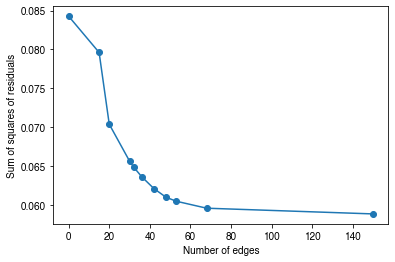

In [49]:
tmp = sorted([(s.n_edges, s.mssr) for s in sols_eta.values()])
plt.plot(*zip(*tmp), '-o');
plt.xlabel("Number of edges");
plt.ylabel("Sum of squares of residuals");

Roughly 40 edges seems to give a good tradeoff between model complexity and model fit.
Let's perform a bootstrap to see which edges are recurrently added. 
This is then the model topology we will use.

In [10]:
#print(sols_eta[0.4].n_edges)
ETA = 0.4

In [18]:
# %%capture
# sol_bootstrap_mra=[]
# NBOOTSTRAP = 40
# NBSTRPCELLS=len(rglob_mra.columns)
# for bstr in range(NBOOTSTRAP):
#     bstrp_cells = random.choices(list(rglob_mra.columns), k=NBSTRPCELLS)
#     bstrp_cell_names = ['b'+str(idx)+"."+bstrp_cells[idx] for idx in range(NBSTRPCELLS)]
#     bstrp_rglob = rglob_mra[bstrp_cells]
#     bstrp_rglob.columns = bstrp_cell_names
#     bstrp_rtot = rtot_mra[bstrp_cells]
#     bstrp_rtot.columns = bstrp_cell_names
#     bstrp_df_annot = df_annot.loc[bstrp_cells]
#     bstrp_df_annot["bstrp_id"] = ['b'+str(idx)+"."+bstrp_cells[idx] for idx in range(NBSTRPCELLS)]

#     bstrp_cell_annot = dict()
#     for tx in bstrp_df_annot.treatment.unique():
#         bstrp_cell_annot[tx] = list(bstrp_df_annot[bstrp_df_annot.treatment == tx].bstrp_id)
#     scd = scmra.ScData(bstrp_rglob, bstrp_rtot, cell_annot=bstrp_cell_annot, tx_annot=tx_annot)
#     scp = scmra.ScMraProblem(scd, eta=ETA, alpha=ALPHA)
#     scmra.sccplex.set_interactions_status(scp, CANNONINCAL_EDGES, 1)
#     scmra.sccplex.set_interactions_status(scp, OUTPUT_EDGES, 0)
#     scp.cpx.solve()
#     sol_bootstrap_mra.append(scmra.ScMraResult(scp))

# with open('../../results/scIDseq/bootstraps/mra_minimal.pickle', 'wb') as f:
#     pickle.dump(sol_bootstrap_mra, f)

with open('../../results/scIDseq/bootstraps/mra_minimal.pickle', 'rb') as f:
    sol_bootstrap_mra = pickle.load(f)

In [19]:
def added_edges(solution, given_edges):
    diff_edges = []
    for i, j in np.nditer(np.nonzero(np.array(solution.imap))):
        diff_edges.append((solution.nodes[i], solution.nodes[j]))
    return set(diff_edges) - set(given_edges)


addCount = dict()
solCount = 0
#for param, loocv_sol in loocv_solution.items():
for sol in sol_bootstrap_mra:
    solCount +=1
    for edge in added_edges(sol, CANNONICAL_EDGES):
        if edge in addCount:
            addCount[edge] += 1
        else:
            addCount[edge] = 1

addCount = pd.DataFrame.from_dict(addCount, orient="index")
addCount.index.name = 'edge'
addCount = addCount.sort_values(0, ascending=False)
addCount.columns = ['occurrences']
addCount["fraction"] = np.round(addCount.occurrences/solCount, 2)
addCount

,occurrences,fraction
edge,,
"(AKT1, RPS6)",40,1.00
"(CDC2, MTOR)",40,1.00
"(CFOS, MTOR)",40,1.00
"(AKT1, GSK3B)",40,1.00
"(RB, GSK3B)",40,1.00
"(CYCLINB1, RB)",40,1.00
"(RB, RPS6)",40,1.00
"(RPS6, RB)",40,1.00
"(ERK12, RSK1T359)",40,1.00


For convinience, we restrict the network topology to edges that are recurrently identified (>50%) in the bootstrap.

In [55]:
recurrent_additions = list(addCount[addCount.fraction > 0.5].index)
SELECTED_EDGES = CANNONICAL_EDGES + recurrent_additions
len(SELECTED_EDGES)

42

In [56]:
UNSELECTED_EDGES = list(set(ALL_EDGES) - set(SELECTED_EDGES))

In [58]:
%%capture
scp = scmra.ScMraProblem(scd_mra, eta=0.99, alpha=ALPHA)
scmra.sccplex.set_interactions_status(scp, SELECTED_EDGES, 1)
scmra.sccplex.set_interactions_status(scp, UNSELECTED_EDGES, 0)
scp.cpx.solve()
sol_mra = scmra.ScMraResult(scp)

scp = scmra.ScMraProblem(scd_mra, eta=ETA, alpha=ALPHA)
scmra.sccplex.set_interactions_status(scp, SELECTED_EDGES, 1)
scmra.sccplex.set_interactions_status(scp, OUTPUT_EDGES, 0)
scp.cpx.solve()
sol_mra2 = scmra.ScMraResult(scp)

Restricting the topology to recurrently added edges gives nearly identical mssr compared to optimization (when # of edges is the same)

In [59]:
sol_mra.n_edges, sol_mra2.n_edges
sol_mra.mssr/sol_mra2.mssr

1.010424781627514

### Compare the clusters

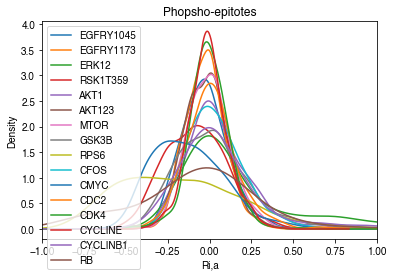

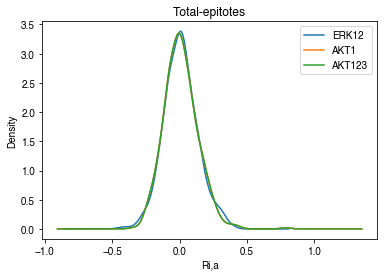

In [65]:
df_lst = []

# For each cluster
for clust_id, cells in group_annot.items():
    # Get median of EGF treated cells.
    ctr_cells = set(cells).intersection(cell_annot["EGF"])
    ctr_median = dat.loc[ctr_cells].median()

    # Median center cells per cluster
    dat_scaled = (dat.loc[cells] - ctr_median) / ctr_median
    #dat_scaled = dat_scaled.transpose()
    df_lst.append(dat_scaled)

# Combine data from all clusters again (and retain old cell order) 
dat_scaled = pd.concat(df_lst, axis=0).loc[dat.index]
rglob_cnr_full = dat_scaled[ab_use_phospho].transpose()
rglob_cnr_full.index = [ab_mapping_phospho[ab] for ab in rglob_cnr_full.index]

abs_use, nodes_use = zip(*[(ab, node) for node, ab in ab_mapping_tot_inv.items()])

rtot_cnr_full = dat_scaled[list(abs_use)].transpose()
rtot_cnr_full.index = nodes_use
del abs_use, nodes_use


# Plot the disctributions
rglob_cnr_full.transpose().plot.kde();
plt.xlim(-1, 1)
plt.xlabel("Ri,a");
plt.ylabel("Density")
plt.title("Phopsho-epitotes");
plt.show();

rtot_cnr_full.transpose().plot.kde();
plt.xlabel("Ri,a");
plt.ylabel("Density")
plt.title("Total-epitotes");

In [67]:
%%capture
scd_cnr_full = scmra.ScData(
    rglob_cnr_full, rtot_cnr_full, 
    group_annot=group_annot, cell_annot=cell_annot, tx_annot=tx_annot
)

In [73]:
%%capture
# sols_theta_cnr_full = dict()
# THETA_VALS = [0, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.5, 1., 10]
THETA_VALS = [2., 5.]
for theta in THETA_VALS:
    scp = scmra.ScCnrProblem(scd_cnr_full, eta=0.,  theta=theta, alpha=ALPHA)
    scmra.sccplex.set_interactions_status(scp, SELECTED_EDGES, 1)
    scmra.sccplex.set_interactions_status(scp, UNSELECTED_EDGES, 0)
    scp.cpx.solve()
    sols_theta_cnr_full[theta] = scmra.ScCnrResult(scp)

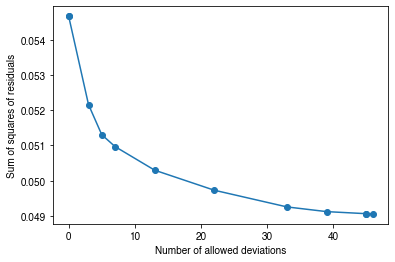

In [74]:
tmp = sorted([(
    sum(s.allowed_deviations.values()), 
    np.mean(np.array(np.square(pd.concat([s.residuals_incomplete, s.residuals_complete]))).flatten())) 
    for s in sols_theta_cnr_full.values()])
plt.plot(*zip(*tmp), '-o');
plt.xlabel("Number of allowed deviations");
plt.ylabel("Sum of squares of residuals");



Using $\theta=0.3$ gives a good trade-off between residuals and model complexity

In [81]:
THETA = 0.3
sum(sols_theta_cnr_full[THETA].allowed_deviations.values())

13.0

In [102]:
%%capture
# sol_bootstrap_cnr_full=[]
NBOOTSTRAP = 40
NBSTRPCELLS=len(rglob_cnr_full.columns)
for bstr in range(NBOOTSTRAP):
    # Prepare the boostrap data =======================================
    bstrp_cells = random.choices(list(rglob_cnr_full.columns), k=NBSTRPCELLS)
    bstrp_cell_names = ['b'+str(idx)+"."+bstrp_cells[idx] for idx in range(NBSTRPCELLS)]
    bstrp_rglob = rglob_cnr_full[bstrp_cells]
    bstrp_rglob.columns = bstrp_cell_names
    bstrp_rtot = rtot_cnr_full[bstrp_cells]
    bstrp_rtot.columns = bstrp_cell_names
    bstrp_df_annot = df_annot.loc[bstrp_cells]
    bstrp_df_annot["bstrp_id"] = ['b'+str(idx)+"."+bstrp_cells[idx] for idx in range(NBSTRPCELLS)]

    bstrp_cell_annot = dict()
    for tx in bstrp_df_annot.treatment.unique():
        bstrp_cell_annot[tx] = list(bstrp_df_annot[bstrp_df_annot.treatment == tx].bstrp_id)
        
    bstrp_group_annot = dict()
    for group in bstrp_df_annot.cluster.unique():
        bstrp_group_annot[str(group)] = list(bstrp_df_annot[bstrp_df_annot.cluster == group].bstrp_id)

    # Perform the CNR optimization =======================================
    scd = scmra.ScData(
        bstrp_rglob, bstrp_rtot, 
        group_annot=bstrp_group_annot, cell_annot=bstrp_cell_annot, tx_annot=tx_annot
    )   
    scp = scmra.ScCnrProblem(scd, eta=0., theta=THETA, alpha=ALPHA)
    scmra.sccplex.set_interactions_status(scp, SELECTED_EDGES, 1)
    scmra.sccplex.set_interactions_status(scp, UNSELECTED_EDGES, 0)
    scp.cpx.solve()
    sol_bootstrap_cnr_full.append(scmra.ScCnrResult(scp))

with open('../../results/scIDseq/bootstraps/cnr_minimal_full.pickle', 'wb') as f:
    pickle.dump(sol_bootstrap_cnr_full, f)

# with open('../../results/scIDseq/bootstraps/cnr_minimal_full.pickle', 'rb') as f:
#     sol_bootstrap_cnr_full = pickle.load(f)

In [163]:
df = pd.concat([s.deviations_overview for s in sol_bootstrap_cnr_full])
recur_diffs = df.index.value_counts()/len(sol_bootstrap_cnr_full)
recur_diffs = pd.DataFrame({"fraction": recur_diffs[recur_diffs > 0.8]})
recur_diffs



Index(['r_ERK12_EGFRY1045', 'r_RPS6_RB', 'r_RB_GSK3B', 'r_ERK12_RPS6',
       'r_RB_RPS6', 'r_ERK12_GSK3B', 'r_ERK12_RSK1T359', 'r_RPS6_AKT1',
       's_ERK12', 'r_CFOS_MTOR', 'r_RPS6_RSK1T359', 'r_ERK12_EGFRY1173',
       'r_CYCLINB1_EGFRY1045'],
      dtype='object')

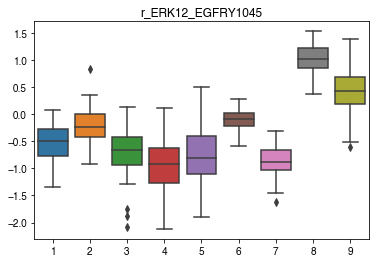

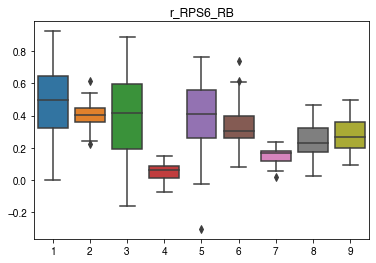

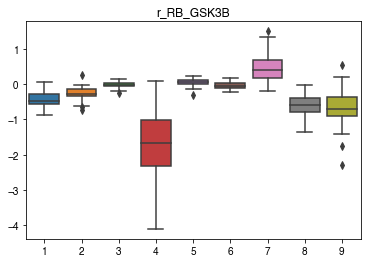

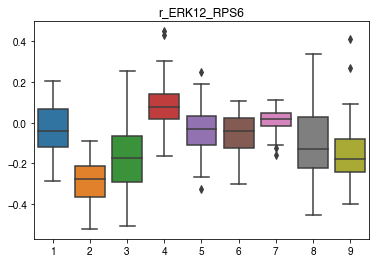

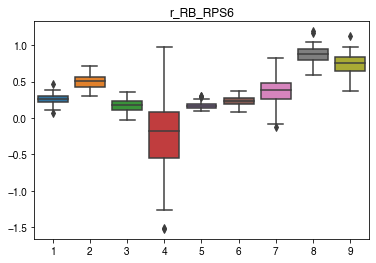

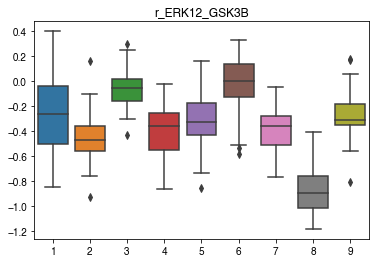

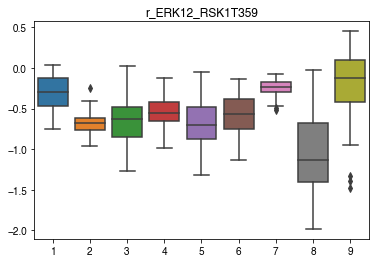

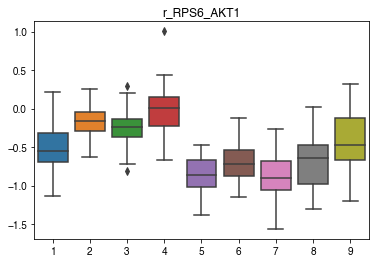

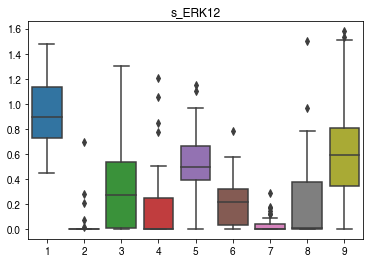

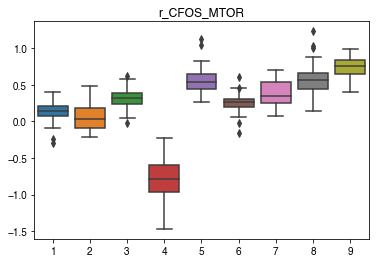

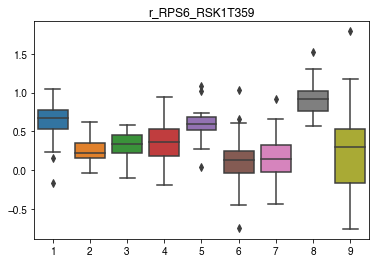

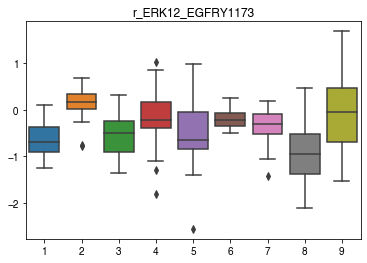

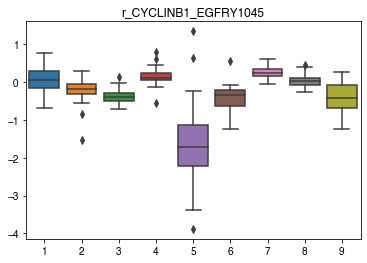

In [168]:
for par in list(recur_diffs.index):
    sns.boxplot(
        x="variable", y="value",  data = pd.melt(df.loc[par]),
        order=["1", "2", "3", "4", "5", "6", "7", "8", "9"],
        );
    plt.xlabel("")
    plt.ylabel("")
    plt.title(par)
    plt.show();


### Cluster 2

Beware: Rows of perturbation data are reordered:
old:	['EGFRY1045', 'EGFRY1173', 'ERK12', 'RSK1T359', 'AKT1', 'AKT123', 'MTOR', 'GSK3B', 'RPS6', 'CFOS', 'CMYC', 'CDC2', 'CDK4', 'CYCLINE', 'CYCLINB1', 'RB']
new:	['ERK12', 'AKT1', 'AKT123', 'EGFRY1045', 'EGFRY1173', 'RSK1T359', 'MTOR', 'GSK3B', 'RPS6', 'CFOS', 'CMYC', 'CDC2', 'CDK4', 'CYCLINE', 'CYCLINB1', 'RB']


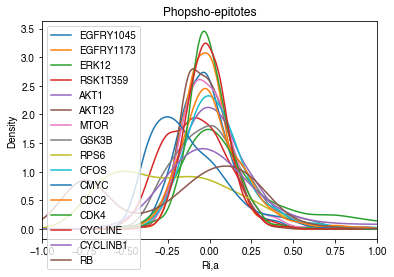

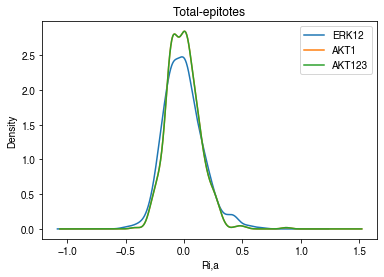

In [172]:
CLUST = 2

group_annot_c2 = {
    "C2": list(df_annot[df_annot.cluster == CLUST].index),
    "NotC2": list(df_annot[df_annot.cluster != CLUST].index),
}


df_lst = []
# For each cluster
for clust_id, cells in group_annot_c2.items():
    # Get median of EGF treated cells.
    ctr_cells = set(cells).intersection(cell_annot["EGF"])
    ctr_median = dat.loc[ctr_cells].median()

    # Median center cells per cluster
    dat_scaled = (dat.loc[cells] - ctr_median) / ctr_median
    #dat_scaled = dat_scaled.transpose()
    df_lst.append(dat_scaled)

# Combine data from all clusters again (and retain old cell order) 
dat_scaled = pd.concat(df_lst, axis=0).loc[dat.index]
rglob_cnr_c2 = dat_scaled[ab_use_phospho].transpose()
rglob_cnr_c2.index = [ab_mapping_phospho[ab] for ab in rglob_cnr_c2.index]

abs_use, nodes_use = zip(*[(ab, node) for node, ab in ab_mapping_tot_inv.items()])

rtot_cnr_c2 = dat_scaled[list(abs_use)].transpose()
rtot_cnr_c2.index = nodes_use
del abs_use, nodes_use

scd_cnr_c2 = scmra.ScData(
    rglob_cnr_c2, rtot_cnr_c2, 
    group_annot=group_annot_c2, cell_annot=cell_annot, tx_annot=tx_annot
)


# Plot the disctributions
rglob_cnr_c2.transpose().plot.kde();
plt.xlim(-1, 1)
plt.xlabel("Ri,a");
plt.ylabel("Density")
plt.title("Phopsho-epitotes");
plt.show();

rtot_cnr_c2.transpose().plot.kde();
plt.xlabel("Ri,a");
plt.ylabel("Density")
plt.title("Total-epitotes");

We will first scan over $\eta$ to establish a sensible value to use. 
This will be identified by plotting residuals against number of edges included in the model.

In [192]:
%%capture
sols_theta_c2 = dict()
THETA_VALS = [0, 0.01, 0.05, 0.1, 0.2, 0.4, 0.5, 10]
for theta in THETA_VALS:
    scp = scmra.ScCnrProblem(scd_cnr_c2, eta=0.,  theta=theta, alpha=ALPHA)
    scmra.sccplex.set_interactions_status(scp, SELECTED_EDGES, 1)
    scmra.sccplex.set_interactions_status(scp, UNSELECTED_EDGES, 0)
    scp.cpx.solve()
    sols_theta_c2[theta] = scmra.ScCnrResult(scp)

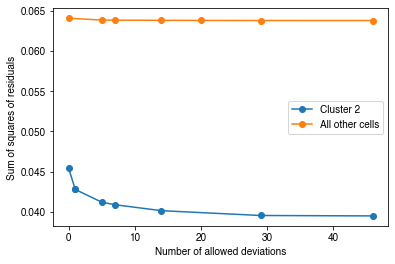

In [194]:
# tmp = sorted([(
#     sum(s.allowed_deviations.values()), 
#     np.mean(np.array(np.square(
#         pd.concat([s.residuals_incomplete, s.residuals_complete]))).flatten())) 
#     for s in sols_theta.values()])
# plt.plot(*zip(*tmp), '-o', label="All cells", c = "gray");
tmp = sorted([(
    sum(s.allowed_deviations.values()), 
    np.mean(np.array(np.square(pd.concat([s.residuals_incomplete, s.residuals_complete])[group_annot_c2["C2"]])).flatten())) 
    for s in sols_theta_c2.values()])
plt.plot(*zip(*tmp), '-o', label="Cluster 2");
tmp = sorted([(
    sum(s.allowed_deviations.values()), 
    np.mean(np.array(np.square(pd.concat([s.residuals_incomplete, s.residuals_complete])[group_annot_c2["NotC2"]])).flatten())) 
    for s in sols_theta.values()])
plt.plot(*zip(*tmp), '-o', label="All other cells");
plt.legend();
plt.xlabel("Number of allowed deviations");
plt.ylabel("Sum of squares of residuals");



In [200]:
print(sols_theta_c2[0.05].n_deviations)
print(sols_theta_c2[0.05].mssr)
sols_theta_c2[0.05].deviations_overview


14.0
0.05989410098298502


,C2,NotC2,mean
r_AKT1_RPS6,-0.0621071,-0.168471,-0.115289
r_CMYC_GSK3B,-0.203458,-0.383815,-0.293637
r_CYCLINB1_EGFRY1045,-0.199079,-0.768682,-0.483881
r_CYCLINB1_EGFRY1173,-0.0664106,-0.987711,-0.527061
r_CYCLINB1_MTOR,-0.346739,0.64447,0.148865
r_CYCLINB1_RB,0.115321,0.269796,0.192558
r_CYCLINB1_RSK1T359,0.287622,-0.759343,-0.23586
r_ERK12_RPS6,-0.330674,-0.17647,-0.253572
r_MTOR_AKT1,0.0717415,0.34334,0.207541
r_RB_RPS6,0.529976,0.637871,0.583924


In [204]:
# %%capture
# sol_bootstrap_cnr_c2=[]
# NBOOTSTRAP = 50
# NBSTRPCELLS=len(rglob_cnr_c2.columns)
# for bstr in range(NBOOTSTRAP):
#     bstrp_cells = random.choices(list(rglob_cnr_c2.columns), k=NBSTRPCELLS)
#     bstrp_cell_names = ['b'+str(idx)+"."+bstrp_cells[idx] for idx in range(NBSTRPCELLS)]
#     bstrp_rglob = rglob_cnr_c2[bstrp_cells]
#     bstrp_rglob.columns = bstrp_cell_names
#     bstrp_rtot = rtot_cnr_c2[bstrp_cells]
#     bstrp_rtot.columns = bstrp_cell_names
#     bstrp_df_annot = df_annot.loc[bstrp_cells]
#     bstrp_df_annot["bstrp_id"] = ['b'+str(idx)+"."+bstrp_cells[idx] for idx in range(NBSTRPCELLS)]

#     bstrp_cell_annot = dict()
#     for tx in bstrp_df_annot.treatment.unique():
#         bstrp_cell_annot[tx] = list(bstrp_df_annot[bstrp_df_annot.treatment == tx].bstrp_id)
#     bstrp_group_annot = {
#         "C2": list(bstrp_df_annot[bstrp_df_annot.cluster == 2].bstrp_id),
#         "NotC2": list(bstrp_df_annot[bstrp_df_annot.cluster != 2].bstrp_id),
#     }
#     scd = scmra.ScData(bstrp_rglob, bstrp_rtot, group_annot=bstrp_group_annot, cell_annot=bstrp_cell_annot, tx_annot=tx_annot)
#     scp = scmra.ScCnrProblem(scd, eta=0., theta=0.05, alpha=ALPHA)
#     scmra.sccplex.set_interactions_status(scp, SELECTED_EDGES, 1)
#     scmra.sccplex.set_interactions_status(scp, UNSELECTED_EDGES, 0)
#     scp.cpx.solve()
#     sol_bootstrap_cnr_c2.append(scmra.ScCnrResult(scp))

with open('../../results/scIDseq/bootstraps/cnr_minimal_c2.pickle', 'wb') as f:
    pickle.dump(sol_bootstrap_cnr_c2, f)
    
with open('../../results/scIDseq/bootstraps/cnr_minimal_c2.pickle', 'rb') as f:
    sol_bootstrap_cnr_c2 = pickle.load(f)

In [225]:
df_c2 = pd.concat([s.deviations_overview for s in sol_bootstrap_cnr_c2])
recur_diffs_c2 = df.index.value_counts()/len(sol_bootstrap_cnr_c2)
recur_diffs_c2 = pd.DataFrame({"fraction": recur_diffs_c2[recur_diffs_c2 > 0.25]})
recur_diffs_c2
# list(recur_diffs[recur_diffs > 0.5].index)


,fraction
r_RB_RPS6,1.00
r_CYCLINB1_EGFRY1173,1.00
r_MTOR_AKT123,0.98
r_CDC2_MTOR,0.98
r_RB_GSK3B,0.96
r_CMYC_RPS6,0.92
r_CYCLINB1_MTOR,0.90
r_CYCLINB1_EGFRY1045,0.88
r_GSK3B_ERK12,0.86
r_RPS6_AKT1,0.82


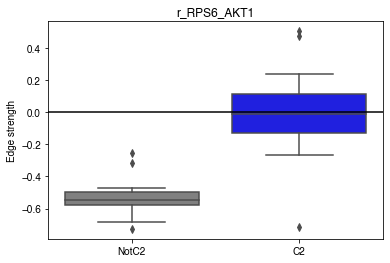

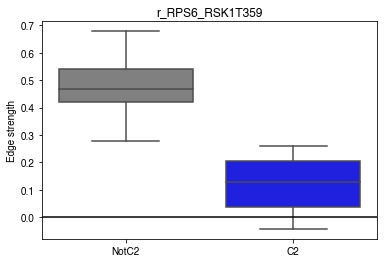

In [230]:
def plot_cnr_c2(par):
    sns.boxplot(
        x="variable", y="value",  data = pd.melt(df_c2.loc[par]),
        order=["NotC2", "C2"],
        palette={"NotC2": "gray", "C2": "blue"}
    );
    plt.xlabel("")
    plt.ylabel("Edge strength")
    plt.axhline(0, c="black")
    plt.title(par)
    plt.show();
plot_cnr_c2("r_RPS6_AKT1")
plot_cnr_c2("r_RPS6_RSK1T359")

### Cluster 6

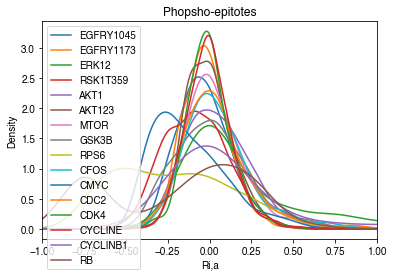

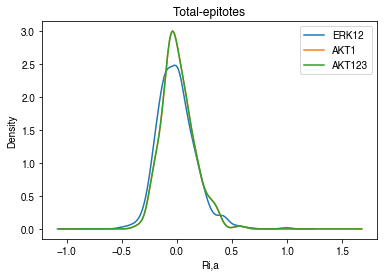

In [209]:
CLUST = 6

group_annot_c6 = {
    "C6": list(df_annot[df_annot.cluster == CLUST].index),
    "NotC6": list(df_annot[df_annot.cluster != CLUST].index),
}


df_lst = []
# For each cluster
for clust_id, cells in group_annot_c6.items():
    # Get median of EGF treated cells.
    ctr_cells = set(cells).intersection(cell_annot["EGF"])
    ctr_median = dat.loc[ctr_cells].median()

    # Median center cells per cluster
    dat_scaled = (dat.loc[cells] - ctr_median) / ctr_median
    #dat_scaled = dat_scaled.transpose()
    df_lst.append(dat_scaled)

# Combine data from all clusters again (and retain old cell order) 
dat_scaled = pd.concat(df_lst, axis=0).loc[dat.index]
rglob_cnr_c6 = dat_scaled[ab_use_phospho].transpose()
rglob_cnr_c6.index = [ab_mapping_phospho[ab] for ab in rglob_cnr_c6.index]

abs_use, nodes_use = zip(*[(ab, node) for node, ab in ab_mapping_tot_inv.items()])

rtot_cnr_c6 = dat_scaled[list(abs_use)].transpose()
rtot_cnr_c6.index = nodes_use
del abs_use, nodes_use


# Plot the disctributions
rglob_cnr_c6.transpose().plot.kde();
plt.xlim(-1, 1)
plt.xlabel("Ri,a");
plt.ylabel("Density")
plt.title("Phopsho-epitotes");
plt.show();

rtot_cnr_c6.transpose().plot.kde();
plt.xlabel("Ri,a");
plt.ylabel("Density")
plt.title("Total-epitotes");

In [210]:
%%capture
scd_cnr_c6 = scmra.ScData(
    rglob_cnr_c6, rtot_cnr_c6, 
    group_annot=group_annot_c6, cell_annot=cell_annot, tx_annot=tx_annot
)

In [211]:
%%capture
sols_theta_c6 = dict()
THETA_VALS = [0, 0.01, 0.025, 0.05, 0.1, 0.2, 10]
for theta in THETA_VALS:
    scp = scmra.ScCnrProblem(scd_cnr_c6, eta=0.,  theta=theta, alpha=ALPHA)
    scmra.sccplex.set_interactions_status(scp, SELECTED_EDGES, 1)
    scmra.sccplex.set_interactions_status(scp, UNSELECTED_EDGES, 0)
    scp.cpx.solve()
    sols_theta_c6[theta] = scmra.ScCnrResult(scp)

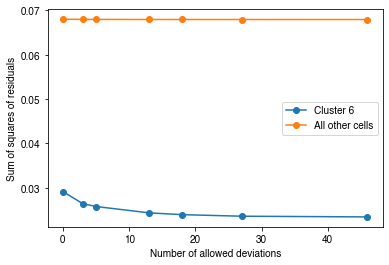

In [212]:
tmp = sorted([(
    sum(s.allowed_deviations.values()), 
    np.mean(np.array(np.square(pd.concat([s.residuals_incomplete, s.residuals_complete])[group_annot_c6["C6"]])).flatten())) 
    for s in sols_theta_c6.values()])
plt.plot(*zip(*tmp), '-o', label="Cluster 6");
tmp = sorted([(
    sum(s.allowed_deviations.values()), 
    np.mean(np.array(np.square(pd.concat([s.residuals_incomplete, s.residuals_complete])[group_annot_c6["NotC6"]])).flatten())) 
    for s in sols_theta_c6.values()])
plt.plot(*zip(*tmp), '-o', label="All other cells");
plt.legend();
plt.xlabel("Number of allowed deviations");
plt.ylabel("Sum of squares of residuals");



In [219]:
sols_theta_c6[0.05].deviations_overview

,C6,NotC6,mean
r_CDC2_MTOR,0.382286,0.807865,0.595076
r_CFOS_RB,0.0986704,-0.156861,-0.0290953
r_CMYC_RPS6,0.0167354,0.183486,0.100111
r_CYCLINB1_EGFRY1045,-0.244501,-0.779213,-0.511857
r_CYCLINB1_EGFRY1173,0.219934,-0.966212,-0.373139
r_CYCLINB1_MTOR,-0.177474,1.05901,0.440766
r_CYCLINB1_RB,-0.0215169,0.251199,0.114841
r_ERK12_GSK3B,-0.0854735,-0.37726,-0.231367
r_ERK12_RPS6,-0.0549979,-0.232853,-0.143925
r_MTOR_AKT123,-0.178973,0.418509,0.119768


In [220]:
%%capture
sol_bootstrap_cnr_c6=[]
NBOOTSTRAP = 50
NBSTRPCELLS=len(rglob_cnr_c6.columns)
for bstr in range(NBOOTSTRAP):
    bstrp_cells = random.choices(list(rglob_cnr_c6.columns), k=NBSTRPCELLS)
    bstrp_cell_names = ['b'+str(idx)+"."+bstrp_cells[idx] for idx in range(NBSTRPCELLS)]
    bstrp_rglob = rglob_cnr_c6[bstrp_cells]
    bstrp_rglob.columns = bstrp_cell_names
    bstrp_rtot = rtot_cnr_c6[bstrp_cells]
    bstrp_rtot.columns = bstrp_cell_names
    bstrp_df_annot = df_annot.loc[bstrp_cells]
    bstrp_df_annot["bstrp_id"] = ['b'+str(idx)+"."+bstrp_cells[idx] for idx in range(NBSTRPCELLS)]

    bstrp_cell_annot = dict()
    for tx in bstrp_df_annot.treatment.unique():
        bstrp_cell_annot[tx] = list(bstrp_df_annot[bstrp_df_annot.treatment == tx].bstrp_id)
    bstrp_group_annot = {
        "C6": list(bstrp_df_annot[bstrp_df_annot.cluster == 6].bstrp_id),
        "NotC6": list(bstrp_df_annot[bstrp_df_annot.cluster != 6].bstrp_id),
    }
    scd = scmra.ScData(bstrp_rglob, bstrp_rtot, group_annot=bstrp_group_annot, cell_annot=bstrp_cell_annot, tx_annot=tx_annot)
    scp = scmra.ScCnrProblem(scd, eta=0., theta=0.01, alpha=ALPHA)
    scmra.sccplex.set_interactions_status(scp, SELECTED_EDGES, 1)
    scmra.sccplex.set_interactions_status(scp, UNSELECTED_EDGES, 0)
    scp.cpx.solve()
    sol_bootstrap_cnr_c6.append(scmra.ScCnrResult(scp))

with open('../../results/scIDseq/bootstraps/cnr_minimal_c6.pickle', 'wb') as f:
    pickle.dump(sol_bootstrap_cnr_c6, f)

In [221]:
df = pd.concat([s.deviations_overview for s in sol_bootstrap_cnr_c6])
recur_diffs = df.index.value_counts()/len(sol_bootstrap_cnr_c6)
recur_diffs = pd.DataFrame({"fraction": recur_diffs[recur_diffs > 0.25]})
recur_diffs
# list(recur_diffs[recur_diffs > 0.5].index)


,fraction
r_RB_RPS6,1.00
r_CYCLINB1_EGFRY1173,1.00
r_MTOR_AKT123,0.98
r_CDC2_MTOR,0.98
r_RB_GSK3B,0.96
r_CMYC_RPS6,0.92
r_CYCLINB1_MTOR,0.90
r_CYCLINB1_EGFRY1045,0.88
r_GSK3B_ERK12,0.86
r_RPS6_AKT1,0.82


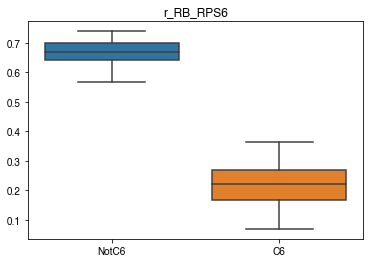

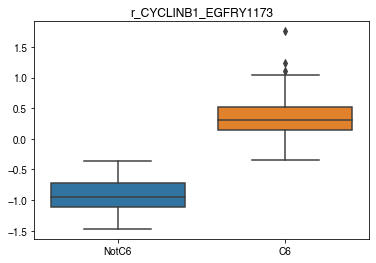

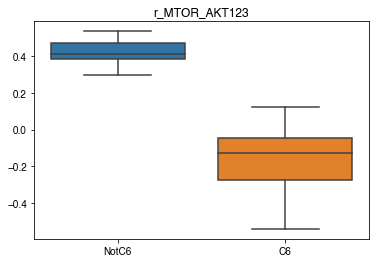

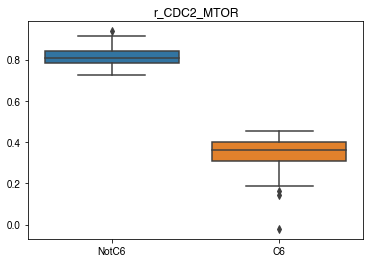

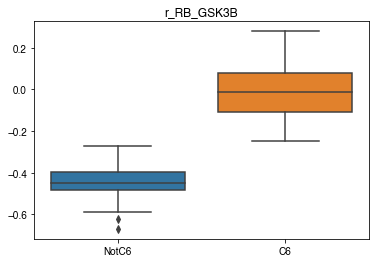

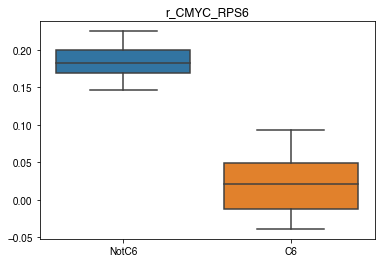

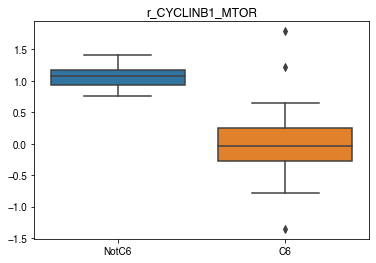

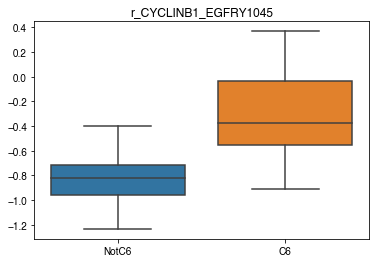

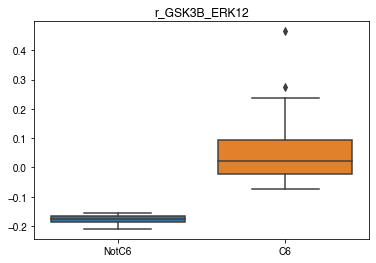

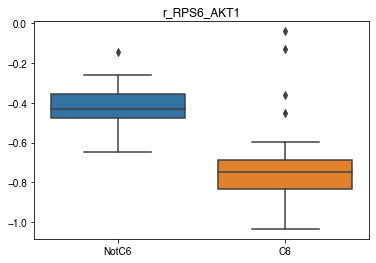

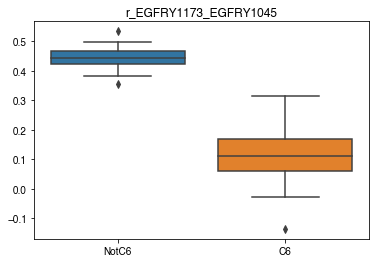

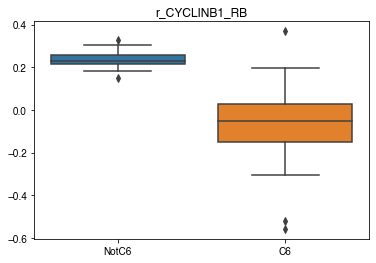

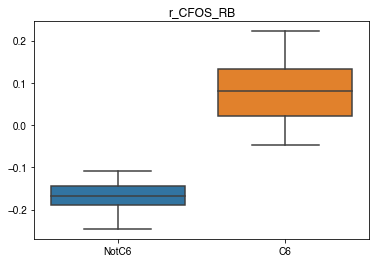

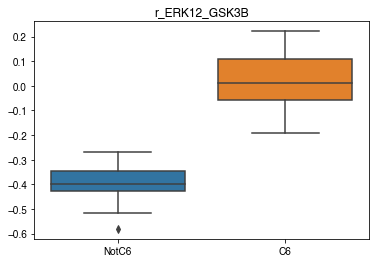

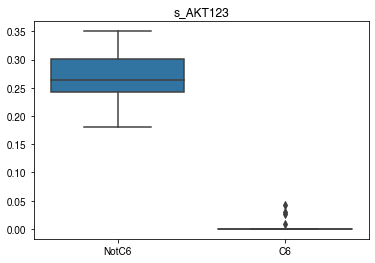

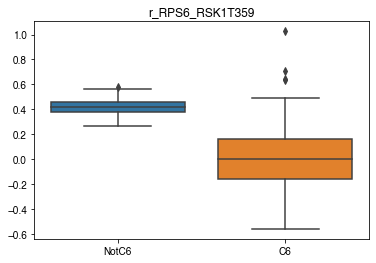

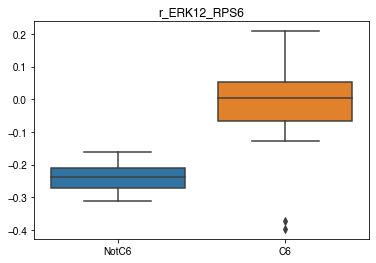

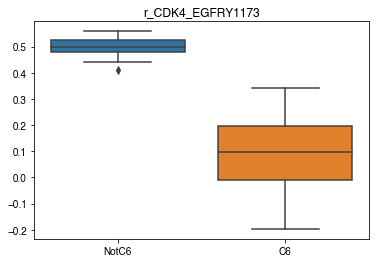

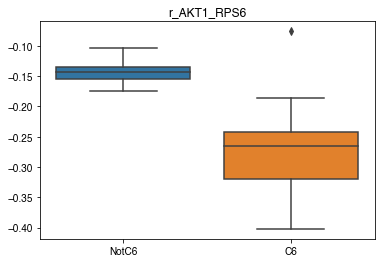

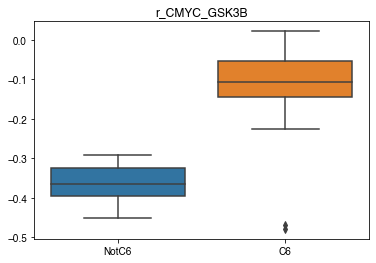

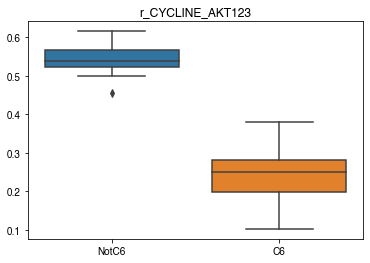

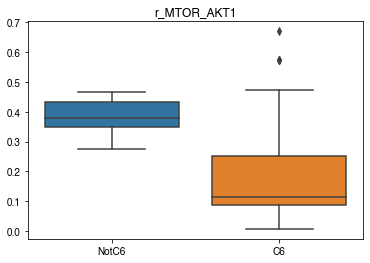

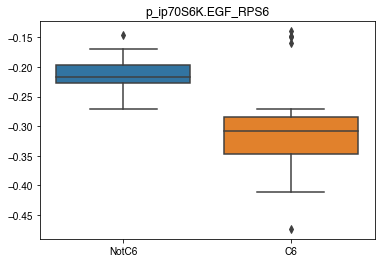

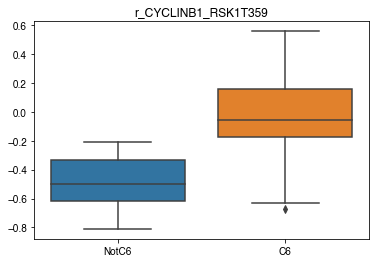

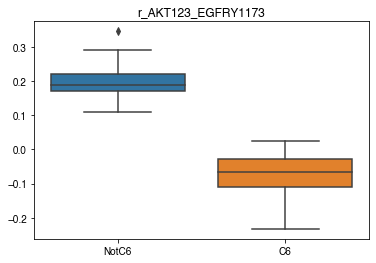

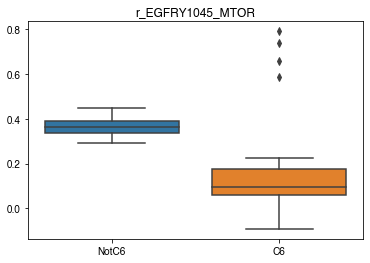

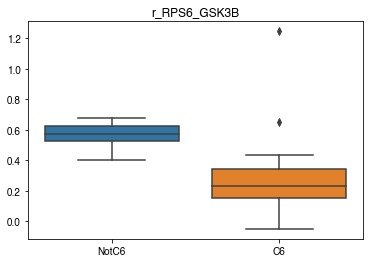

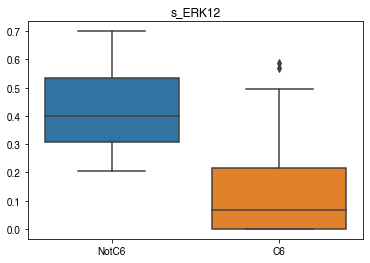

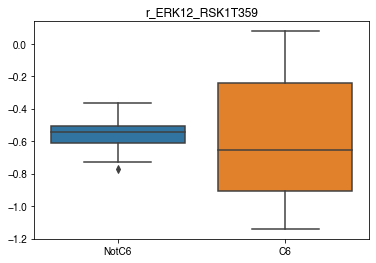

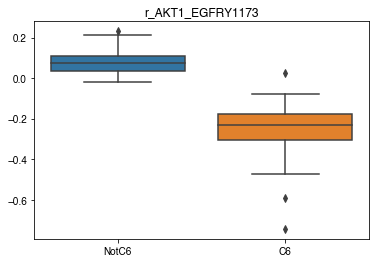

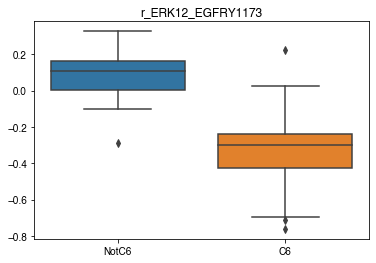

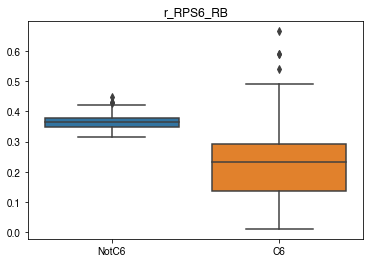

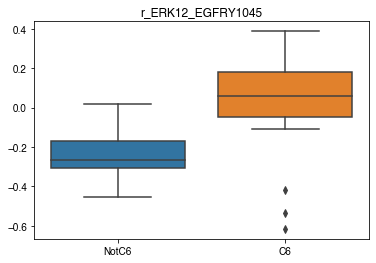

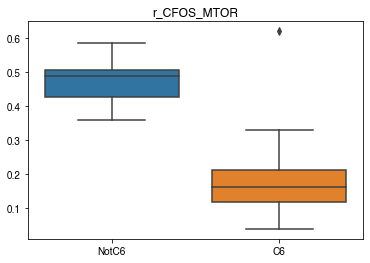

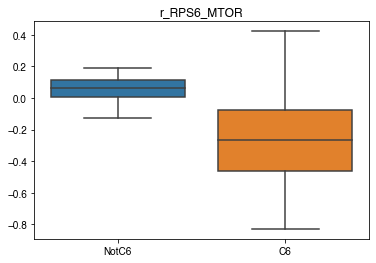

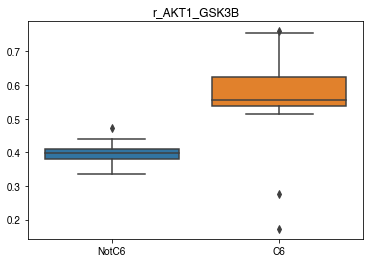

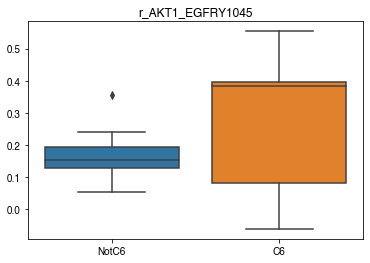

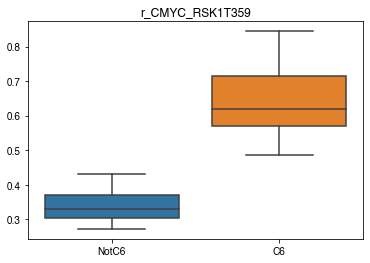

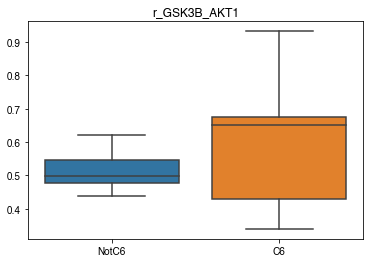

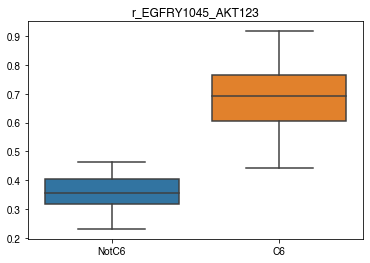

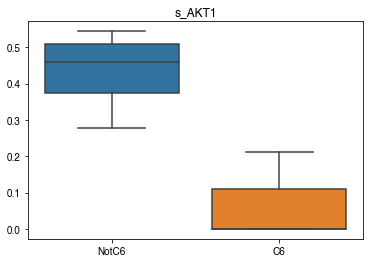

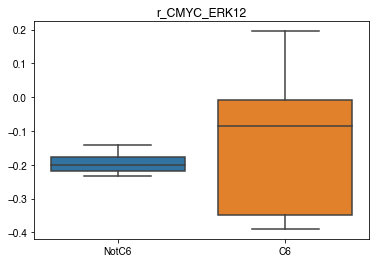

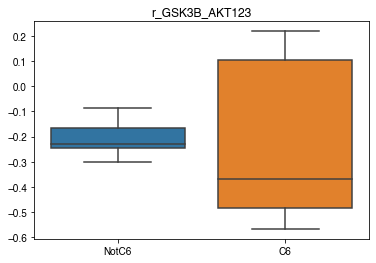

In [224]:
for par in list(recur_diffs.index):
    sns.boxplot(
        x="variable", y="value",  data = pd.melt(df.loc[par]),
        order=["NotC6", "C6"],
        );
    plt.xlabel("")
    plt.ylabel("")
    plt.title(par)
    plt.show();


## Grouping by treatment and cluster

In [ ]:
CLUST = 2

group_annot_cltx_c2 = {
    "CTR.InCluster":     list(df_annot[(df_annot.cluster == CLUST) & (df_annot.treatment == "EGF")].index),
    "CTR.NotInCluster":  list(df_annot[(df_annot.cluster != CLUST) & (df_annot.treatment == "EGF")].index),
    "iRSK.InCluster":    list(df_annot[(df_annot.cluster == CLUST) & (df_annot.treatment == "iRSK.EGF")].index),
    "iRSK.NotInCluster": list(df_annot[(df_annot.cluster != CLUST) & (df_annot.treatment == "iRSK.EGF")].index),
    "iP70.InCluster":    list(df_annot[(df_annot.cluster == CLUST) & (df_annot.treatment == "ip70S6K.EGF")].index),
    "iP70.NotInCluster": list(df_annot[(df_annot.cluster != CLUST) & (df_annot.treatment == "ip70S6K.EGF")].index)
}

# Scale each cluster by it's median (not perturbations are modelled)

df_lst = []
# For each cluster
for group_id, cells in group_annot_cltx.items():
    
    median = dat.loc[cells].median()

    # Median center cells per cluster
    dat_scaled = (dat.loc[cells] - median) / median
    #dat_scaled = dat_scaled.transpose()
    df_lst.append(dat_scaled)

# Combine data from all clusters again (and retain old cell order) 
dat_scaled = pd.concat(df_lst, axis=0).loc[dat.index]
rglob_cnr_cltx_c2 = dat_scaled[ab_use_phospho].transpose()
rglob_cnr_cltx_c2.index = [ab_name_mapping[ab] for ab in rglob_cnr_cltx_c2.index]

rtot_cnr_cltx_c2 = dat_scaled[ab_use_tot].transpose()
rtot_cnr_cltx_c2.index = [ab_name_mapping[ab] for ab in rtot_cnr_cltx_c2.index]


rglob_cnr_cltx_c2.head()
for ab in NODE_NAMES:
    sns.distplot(rglob_cnr_cltx_c2.loc[ab], hist = False, kde = True, label=ab)
plt.xlabel("Ri,a");
plt.ylabel("Density");
plt.xlim(-1, 1)
plt.title("Phopsho-epitotes");